# Virtual data set (VDS) reference file for ECCO_L4_OBP_05DEG_DAILY_V4R4B using Virtualizarr


In [78]:
# Built-in packages-----------------
import os
import sys
import shutil

# Filesystem management-----------------
import earthaccess

import fsspec

from obstore.auth.earthdata import NasaEarthdataCredentialProvider
from obstore.store import S3Store
from obspec_utils.registry import ObjectStoreRegistry

# Data handling-----------------
import numpy as np
import xarray as xr
from virtualizarr import open_virtual_dataset
from virtualizarr.parsers import HDFParser
import pandas as pd

# Parallel computing -----------------
import multiprocessing
from dask import delayed
import dask.array as da
from dask.distributed import Client
import coiled

# Other-----------------
import matplotlib.pyplot as plt

## 1. Get Data File S3 endpoints in Earthdata Cloud

In [81]:
# Get Earthdata creds
earthaccess.login()

In [82]:
# Get AWS creds. Note that if you spend more than 1 hour in the notebook, you may have to re-run this line!!!
fs = earthaccess.get_s3_filesystem(daac="PODAAC")
reader_opts = {"storage_options": fs.storage_options}
#creds = fs.storage_options

In [83]:
# Locate CCMP file information / metadata:
shortname = "SASSIE_ECCO_L4_OCN_VEL_LLC1080GRID_DAILY_V1R1"
granule_info = earthaccess.search_data(
    short_name=shortname,
    )

In [84]:
# Get S3 endpoints for all files:
data_s3links = [g.data_links(access="direct")[0] for g in granule_info]
print("Number of granules found =", len(data_s3links))
print("First few granules:")
data_s3links[0:5]

Number of granules found = 2581
First few granules:


['s3://podaac-ops-cumulus-protected/SASSIE_ECCO_L4_OCN_VEL_LLC1080GRID_DAILY_V1R1/OCEAN_VELOCITY_day_mean_2014-01-15_SASSIE_ECCO_V1R1_native_llc1080.nc',
 's3://podaac-ops-cumulus-protected/SASSIE_ECCO_L4_OCN_VEL_LLC1080GRID_DAILY_V1R1/OCEAN_VELOCITY_day_mean_2014-01-16_SASSIE_ECCO_V1R1_native_llc1080.nc',
 's3://podaac-ops-cumulus-protected/SASSIE_ECCO_L4_OCN_VEL_LLC1080GRID_DAILY_V1R1/OCEAN_VELOCITY_day_mean_2014-01-17_SASSIE_ECCO_V1R1_native_llc1080.nc',
 's3://podaac-ops-cumulus-protected/SASSIE_ECCO_L4_OCN_VEL_LLC1080GRID_DAILY_V1R1/OCEAN_VELOCITY_day_mean_2014-01-18_SASSIE_ECCO_V1R1_native_llc1080.nc',
 's3://podaac-ops-cumulus-protected/SASSIE_ECCO_L4_OCN_VEL_LLC1080GRID_DAILY_V1R1/OCEAN_VELOCITY_day_mean_2014-01-19_SASSIE_ECCO_V1R1_native_llc1080.nc']

## 2. Generate single-day reference files

One file per day.

### 2.1 Locate coordinate variable names

These will be stored directly in the VDS ref files.

The coordinate var names are found by opening a sample file and inspecting it's coordinate variables

In [14]:
data_sample = xr.open_dataset(earthaccess.open([granule_info[0]])[0])

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [85]:
grid_vars_reference = ['time', 'i', 'i_g', 'j', 'j_g', 'k', 'k_u', 'k_l', 'k_p1']

In [86]:
# This will be assigned to 'loadable_variables' and needs to be modified per the specific 
# coord names of the data set:
loadable_vars = []
for c in list(data_sample.coords.keys()):
    if c in grid_vars_reference:
        loadable_vars.append(c)

### 2.2 Ref file creation in parallel

In [58]:
# import earthaccess
# from obstore.auth.earthdata import NasaEarthdataCredentialProvider
# from obstore.store import S3Store

# from obspec_utils.registry import ObjectStoreRegistry
# from virtualizarr import open_virtual_dataset
# from virtualizarr.parsers import HDFParser

In [87]:
auth = earthaccess.login()

In [88]:
credentials_url = "https://archive.podaac.earthdata.nasa.gov/s3credentials"
bucket = "s3://podaac-ops-cumulus-protected"

In [89]:
credential_provider = NasaEarthdataCredentialProvider(credentials_url, auth=(auth.username, auth.password))
store = S3Store.from_url(bucket, credential_provider=credential_provider)
registry = ObjectStoreRegistry({bucket: store})

In [90]:
ds = open_virtual_dataset(
    data_s3links[0],
    parser=HDFParser(),
    registry=registry,
    loadable_variables=loadable_vars,
    decode_times=False
)

In [101]:
%%time

virtual_ds_list = []

for p in data_s3links[:10]:
    vds_ref_single = open_virtual_dataset(
        data_s3links[0],
        parser=HDFParser(),
        registry=registry,
        loadable_variables=loadable_vars,
        decode_times=False
    )
    virtual_ds_list.append(vds_ref_single)

CPU times: user 1.37 s, sys: 703 ms, total: 2.08 s
Wall time: 8.51 s


#### Trying to parallelize with local dask cluster

In [94]:
# Check how many cpu's are on this VM:
print("CPU count =", multiprocessing.cpu_count())

CPU count = 4


In [95]:
# Start up cluster and print some information about it:
client = Client(n_workers=4, threads_per_worker=1)
print(client.cluster)
print("View any work being done on the cluster here", client.dashboard_link)

LocalCluster(c2bc15c6, 'tcp://127.0.0.1:38091', workers=4, threads=4, memory=14.41 GiB)
View any work being done on the cluster here https://cluster-utmck.dask.host/jupyter/proxy/8787/status


In [97]:
%%time
# Create individual references:
open_vds_par = delayed(open_virtual_dataset)
tasks = [
    open_vds_par(
        p, 
        parser=HDFParser(),
        registry=registry,
        loadable_variables=loadable_vars,
        decode_times=False
    ) 
    for p in data_s3links[:40]
    ]
virtual_ds_list = list(da.compute(*tasks)) # The xr.combine_nested() function below needs a list rather than a tuple.

2026-01-31 00:23:43,496 - distributed.worker - WARNING - Compute Failed
Key:       open_virtual_dataset-e8eb9a7f-4516-46b1-84cd-2f5817c4264e
Function:  execute_task
args:      ((<function apply at 0x797f4f982020>, <function open_virtual_dataset at 0x797f276dc720>, ['s3://podaac-ops-cumulus-protected/SASSIE_ECCO_L4_OCN_VEL_LLC1080GRID_DAILY_V1R1/OCEAN_VELOCITY_day_mean_2014-02-19_SASSIE_ECCO_V1R1_native_llc1080.nc'], (<class 'dict'>, [['parser', <virtualizarr.parsers.hdf.hdf.HDFParser object at 0x797f26f99d30>], ['registry', <obspec_utils.registry.ObjectStoreRegistry object at 0x797f26f99e80>], ['loadable_variables', ['time', 'j', 'j_g', 'i', 'i_g', 'k', 'k_u', 'k_l', 'k_p1']], ['decode_times', False]])))
kwargs:    {}
Exception: 'UnauthenticatedError(\'The operation lacked valid authentication credentials for path External AWS credential provider: SystemError: <class \\\'requests.models.Request\\\'> returned a result with an exception set\\n\\nDebug source:\\nUnauthenticated {\\n    pa

UnauthenticatedError: The operation lacked valid authentication credentials for path External AWS credential provider: SystemError: <class 'requests.models.Request'> returned a result with an exception set

Debug source:
Unauthenticated {
    path: "External AWS credential provider",
    source: PyErr {
        type: <class 'SystemError'>,
        value: SystemError("<class 'requests.models.Request'> returned a result with an exception set"),
        traceback: Some(
            "Traceback (most recent call last):\n  File \"/opt/coiled/env/lib/python3.13/site-packages/obstore/auth/earthdata.py\", line 182, in __call__\n    credentials = self._refresh_with_basic_auth(self._auth)\n  File \"/opt/coiled/env/lib/python3.13/site-packages/obstore/auth/earthdata.py\", line 204, in _refresh_with_basic_auth\n    with self.session.get(self._credentials_url, allow_redirects=False) as r:\n  File \"/opt/coiled/env/lib/python3.13/site-packages/requests/sessions.py\", line 602, in get\n    return self.request(\"GET\", url, **kwargs)\n  File \"/opt/coiled/env/lib/python3.13/site-packages/requests/sessions.py\", line 563, in request\n    req = Request(\n",
        ),
    },
}

/opt/coiled/env/lib/python3.13/site-packages/zarr/codecs/numcodecs/_codecs.py:141: ZarrUserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/opt/coiled/env/lib/python3.13/site-packages/zarr/codecs/numcodecs/_codecs.py:141: ZarrUserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


#### Trying to parallelize with distributed dask cluster

In [91]:
%%time

## --------------------------------------------
## Create single reference files with parallel computing using Coiled
## --------------------------------------------

# Wrap `open_virtual_dataset()` into coiled function and copy to mulitple VM's:
open_vds_par = coiled.function(
    region="us-west-2", spot_policy="on-demand", 
    vm_type="m6i.large", n_workers=15
    )(open_virtual_dataset)

# Begin computations for first year only:
results = open_vds_par.map(
    data_s3links[:100], 
    parser=HDFParser(),
    registry=registry,
    loadable_variables=loadable_vars,
    decode_times=False
    )

virtual_ds_list = []
for r in results:
    virtual_ds_list.append(r)

Output()

╭────────────────────────── Not Synced with Cluster ───────────────────────────╮
│            ╷                                                     ╷           │
│   Package  │ Error                                               │ Risk      │
│ ╶──────────┼─────────────────────────────────────────────────────┼─────────╴ │
│   kerchunk │ Pip check had the following issues that need        │ Warning   │
│            │ resolving:                                          │           │
│            │ kerchunk 0.2.7 has requirement zarr<3, but you have │           │
│            │ zarr 3.1.5.                                         │           │
│            ╵                                                     ╵           │
╰──────────────────────────────────────────────────────────────────────────────╯

Output()

UnauthenticatedError: The operation lacked valid authentication credentials for path External AWS credential provider: SystemError: <class 'requests.models.Request'> returned a result with an exception set

Debug source:
Unauthenticated {
    path: "External AWS credential provider",
    source: PyErr {
        type: <class 'SystemError'>,
        value: SystemError("<class 'requests.models.Request'> returned a result with an exception set"),
        traceback: Some(
            "Traceback (most recent call last):\n  File \"/opt/coiled/env/lib/python3.13/site-packages/obstore/auth/earthdata.py\", line 182, in __call__\n    credentials = self._refresh_with_basic_auth(self._auth)\n  File \"/opt/coiled/env/lib/python3.13/site-packages/obstore/auth/earthdata.py\", line 204, in _refresh_with_basic_auth\n    with self.session.get(self._credentials_url, allow_redirects=False) as r:\n  File \"/opt/coiled/env/lib/python3.13/site-packages/requests/sessions.py\", line 602, in get\n    return self.request(\"GET\", url, **kwargs)\n  File \"/opt/coiled/env/lib/python3.13/site-packages/requests/sessions.py\", line 563, in request\n    req = Request(\n",
        ),
    },
}

In [92]:
len(virtual_ds_list)

4

In [93]:
open_vds_par.cluster.shutdown()

In [106]:
virtual_ds_list[0]

<xarray.Dataset> Size: 2GB
Dimensions:    (time: 1, k: 90, j_g: 1080, i: 1800, k_l: 90, j: 1080,
                i_g: 1800, nb: 4, nv: 2, k_p1: 91, k_u: 90)
Coordinates: (12/23)
    YC_bnds    (j, i, nb) float32 31MB ManifestArray<shape=(1080, 1800, 4), d...
    YU         (j, i_g) float32 8MB ManifestArray<shape=(1080, 1800), dtype=f...
    YV         (j_g, i) float32 8MB ManifestArray<shape=(1080, 1800), dtype=f...
    XC_bnds    (j, i, nb) float32 31MB ManifestArray<shape=(1080, 1800, 4), d...
    Z_bnds     (k, nv) float32 720B ManifestArray<shape=(90, 2), dtype=float3...
    Zl         (k_l) float32 360B ManifestArray<shape=(90,), dtype=float32, c...
    ...         ...
  * i          (i) int32 7kB 0 1 2 3 4 5 6 ... 1794 1795 1796 1797 1798 1799
  * i_g        (i_g) int32 7kB 0 1 2 3 4 5 6 ... 1794 1795 1796 1797 1798 1799
  * k          (k) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k_u        (k_u) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k_l        (k_l) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k_p1       (k_p1) int32 364B 0 1 2 3 4 5 6 7 8 ... 83 84 85 86 87 88 89 90
Dimensions without coordinates: nb, nv
Data variables:
    VVEL       (time, k, j_g, i) float32 700MB ManifestArray<shape=(1, 90, 10...
    WVEL       (time, k_l, j, i) float32 700MB ManifestArray<shape=(1, 90, 10...
    UVEL       (time, k, j, i_g) float32 700MB ManifestArray<shape=(1, 90, 10...
Attributes: (12/58)
    Conventions:                       CF-1.8, ACDD-1.3
    acknowledgement:                   This research was carried out by the J...
    author:                            Marie Zahn, Mike Wood, Ian Fenty, and ...
    cdm_data_type:                     Grid
    comment:                           SASSIE llc1080 V1R1 fields are consoli...
    creator_email:                     marie.j.zahn@jpl.nasa.gov
    ...                                ...
    time_coverage_duration:            P1D
    time_coverage_end:                 2014-01-16T00:00:00
    time_coverage_resolution:          P1D
    time_coverage_start:               2014-01-15T00:00:00
    title:                             SASSIE ECCO Ocean Velocity - Daily Mea...
    uuid:                              b0c588cc-dba7-11f0-aa56-0639fa595dd3

In [107]:
data

<xarray.Dataset> Size: 210GB
Dimensions:    (time: 100, k: 90, j: 1080, i_g: 1800, j_g: 1080, i: 1800,
                k_l: 90, nb: 4, nv: 2, k_p1: 91, k_u: 90)
Coordinates: (12/23)
    XC         (j, i) float32 8MB dask.array<chunksize=(1080, 1800), meta=np.ndarray>
    XC_bnds    (j, i, nb) float32 31MB dask.array<chunksize=(1080, 1800, 4), meta=np.ndarray>
    XU         (j, i_g) float32 8MB dask.array<chunksize=(1080, 1800), meta=np.ndarray>
    XV         (j_g, i) float32 8MB dask.array<chunksize=(1080, 1800), meta=np.ndarray>
    YC         (j, i) float32 8MB dask.array<chunksize=(1080, 1800), meta=np.ndarray>
    YC_bnds    (j, i, nb) float32 31MB dask.array<chunksize=(1080, 1800, 4), meta=np.ndarray>
    ...         ...
  * k          (k) float64 720B nan 1.0 2.0 3.0 4.0 ... 85.0 86.0 87.0 88.0 89.0
  * k_l        (k_l) float64 720B nan 1.0 2.0 3.0 4.0 ... 86.0 87.0 88.0 89.0
  * k_p1       (k_p1) float64 728B nan 1.0 2.0 3.0 4.0 ... 87.0 88.0 89.0 90.0
  * k_u        (k_u) float64 720B nan 1.0 2.0 3.0 4.0 ... 86.0 87.0 88.0 89.0
  * time       (time) datetime64[ns] 800B 2014-01-15T12:00:00 ... 2014-04-24T...
    time_bnds  (time, nv) datetime64[ns] 2kB dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: nb, nv
Data variables:
    UVEL       (time, k, j, i_g) float32 70GB dask.array<chunksize=(1, 15, 270, 450), meta=np.ndarray>
    VVEL       (time, k, j_g, i) float32 70GB dask.array<chunksize=(1, 15, 270, 450), meta=np.ndarray>
    WVEL       (time, k_l, j, i) float32 70GB dask.array<chunksize=(1, 15, 270, 450), meta=np.ndarray>
Attributes: (12/50)
    Conventions:                       CF-1.8, ACDD-1.3
    acknowledgement:                   This research was carried out by the J...
    author:                            Marie Zahn, Mike Wood, Ian Fenty, and ...
    cdm_data_type:                     Grid
    comment:                           SASSIE llc1080 V1R1 fields are consoli...
    creator_email:                     marie.j.zahn@jpl.nasa.gov
    ...                                ...
    source:                            The SASSIE ocean model simulation was ...
    standard_name_vocabulary:          NetCDF Climate and Forecast (CF) Metad...
    summary:                           This dataset provides daily-averaged o...
    time_coverage_duration:            P1D
    time_coverage_resolution:          P1D
    title:                             SASSIE ECCO Ocean Velocity - Daily Mea...

In [105]:
for vds in virtual_ds_list:
    print(np.sum(vds.j.values - virtual_ds_list[0].j.values))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


## 3. Generate combined reference file

In [102]:
%%time
# Create the combined reference
virtual_ds_combined = xr.combine_nested(virtual_ds_list, concat_dim='time', coords='minimal', compat='override', combine_attrs='drop_conflicts')

CPU times: user 21.7 ms, sys: 689 μs, total: 22.4 ms
Wall time: 20.8 ms


In [104]:
# Save in JSON or PARQUET format:
fname_combined_json = shortname + "_virtual_s3" + ".json"
virtual_ds_combined.virtualize.to_kerchunk(fname_combined_json, format='json')

## 4. Test combined reference files

In [113]:
# Get Earthdata creds
earthaccess.login()

In [114]:
# Get AWS creds. Note that if you spend more than 1 hour in the notebook, you may have to re-run this line!!!
fs = earthaccess.get_s3_filesystem(daac="PODAAC")
reader_opts = {"storage_options": fs.storage_options}

In [115]:
def opends_withref(ref, fs_data):
    """
    "ref" is a reference file or object. "fs_data" is a filesystem with credentials to
    access the actual data files. 
    """
    storage_opts = {"fo": ref, "remote_protocol": "s3", "remote_options": fs_data.storage_options}
    fs_ref = fsspec.filesystem('reference', **storage_opts)
    m = fs_ref.get_mapper('')
    data = xr.open_dataset(
        m, engine="zarr", chunks={},
        backend_kwargs={"consolidated": False}
    )
    return data

In [116]:
%%time
data = opends_withref(fname_combined_json, fs)
data

CPU times: user 38.7 ms, sys: 3.77 ms, total: 42.5 ms
Wall time: 41 ms


<xarray.Dataset> Size: 21GB
Dimensions:    (time: 10, k: 90, j: 1080, i_g: 1800, j_g: 1080, i: 1800,
                k_l: 90, k_p1: 91, k_u: 90, nv: 2, nb: 4)
Coordinates:
  * time       (time) int32 40B 193200 193200 193200 ... 193200 193200 193200
  * k          (k) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 4kB 0 1 2 3 4 5 6 ... 1074 1075 1076 1077 1078 1079
  * i_g        (i_g) int32 7kB 0 1 2 3 4 5 6 ... 1794 1795 1796 1797 1798 1799
  * j_g        (j_g) int32 4kB 0 1 2 3 4 5 6 ... 1074 1075 1076 1077 1078 1079
  * i          (i) int32 7kB 0 1 2 3 4 5 6 ... 1794 1795 1796 1797 1798 1799
  * k_l        (k_l) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k_p1       (k_p1) int32 364B 0 1 2 3 4 5 6 7 8 ... 83 84 85 86 87 88 89 90
  * k_u        (k_u) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
Dimensions without coordinates: nv, nb
Data variables: (12/17)
    UVEL       (time, k, j, i_g) float32 7GB dask.array<chunksize=(1, 15, 270, 450), meta=np.ndarray>
    VVEL       (time, k, j_g, i) float32 7GB dask.array<chunksize=(1, 15, 270, 450), meta=np.ndarray>
    WVEL       (time, k_l, j, i) float32 7GB dask.array<chunksize=(1, 15, 270, 450), meta=np.ndarray>
    XC         (j, i) float32 8MB dask.array<chunksize=(1080, 1800), meta=np.ndarray>
    YC         (j, i) float32 8MB dask.array<chunksize=(1080, 1800), meta=np.ndarray>
    XU         (j, i_g) float32 8MB dask.array<chunksize=(1080, 1800), meta=np.ndarray>
    ...         ...
    Zu         (k_u) float32 360B dask.array<chunksize=(90,), meta=np.ndarray>
    Zl         (k_l) float32 360B dask.array<chunksize=(90,), meta=np.ndarray>
    time_bnds  (time, nv) int32 80B dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (j, i, nb) float32 31MB dask.array<chunksize=(1080, 1800, 4), meta=np.ndarray>
    YC_bnds    (j, i, nb) float32 31MB dask.array<chunksize=(1080, 1800, 4), meta=np.ndarray>
    Z_bnds     (k, nv) float32 720B dask.array<chunksize=(90, 2), meta=np.ndarray>
Attributes: (12/59)
    acknowledgement:                   This research was carried out by the J...
    author:                            Marie Zahn, Mike Wood, Ian Fenty, and ...
    cdm_data_type:                     Grid
    Conventions:                       CF-1.8, ACDD-1.3
    creator_email:                     marie.j.zahn@jpl.nasa.gov
    creator_institution:               NASA Jet Propulsion Laboratory (JPL)
    ...                                ...
    date_modified:                     2025-12-18T00:22:52
    identifier_product_doi:            https://doi.org/10.5067/SEL1D-OVE11
    identifier_product_doi_authority:  org.doi
    time_coverage_duration:            P1D
    time_coverage_resolution:          P1D
    coordinates:                       XC_bnds XU XV YC_bnds YU YV Z_bnds Zp1...

In [117]:
data['UVEL'].isel(time=0, k=10)

<xarray.DataArray 'UVEL' (j: 1080, i_g: 1800)> Size: 8MB
dask.array<getitem, shape=(1080, 1800), dtype=float32, chunksize=(270, 450), chunktype=numpy.ndarray>
Coordinates:
  * j        (j) int32 4kB 0 1 2 3 4 5 6 ... 1073 1074 1075 1076 1077 1078 1079
  * i_g      (i_g) int32 7kB 0 1 2 3 4 5 6 ... 1794 1795 1796 1797 1798 1799
    time     int32 4B 193200
    k        int32 4B 10
Attributes:
    _FillValue:             9.96921e+36
    coverage_content_type:  modelResult
    direction:              >0 increases volume
    long_name:              Horizontal velocity in the model +x direction
    standard_name:          sea_water_x_velocity
    units:                  m s-1
    comment:                Horizontal velocity in the +x direction at the 'u...
    valid_min:              -1.0584291219711304
    valid_max:              1.731411099433899
    coordinates:            Z

In [118]:
data['UVEL'].isel(time=0, k=1).plot(x='XU', y='YU')

2026-01-31 00:54:42,659 - distributed.worker - WARNING - Compute Failed
Key:       ('open_dataset-UVEL-getitem-ceff9b661be5d3a9bdc923762ac5a4b3', 0, 1)
Function:  getter
args:      (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x7c9c1fefd380>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None), slice(None, None, None)))))), (0, 1, slice(0, 270, None), slice(450, 900, None)))
kwargs:    {}
Exception: 'TypeError("a bytes-like object is required, not \'NoneType\'")'

2026-01-31 00:54:42,690 - distributed.worker - WARNING - Compute Failed
Key:       ('open_dataset-UVEL-getitem-ceff9b661be5d3a9bdc923762ac5a4b3', 1, 1)
Function:  getter
args:      (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x76551f9d3e00>, key=BasicIndexer((slice(None, None, None), slice(None, None, N

TypeError: a bytes-like object is required, not 'NoneType'

2026-01-31 00:54:50,853 - distributed.worker - WARNING - Compute Failed
Key:       ('open_dataset-UVEL-getitem-ceff9b661be5d3a9bdc923762ac5a4b3', 3, 3)
Function:  getter
args:      (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x7c9c1fefd380>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None), slice(None, None, None)))))), (0, 1, slice(810, 1080, None), slice(1350, 1800, None)))
kwargs:    {}
Exception: 'TypeError("a bytes-like object is required, not \'NoneType\'")'



In [85]:
import cartopy.crs as ccrs


ERROR! Session/line number was not unique in database. History logging moved to new session 5


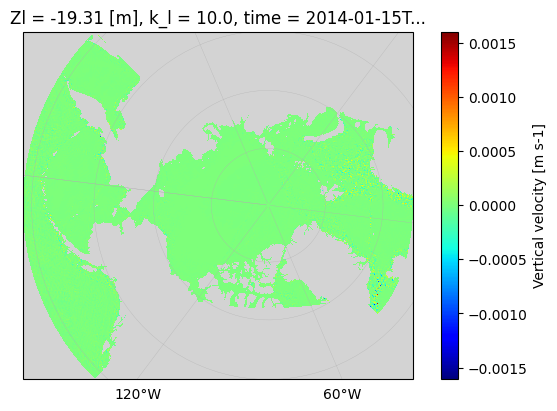

In [86]:
fig = plt.figure(figsize=(7,4), constrained_layout=True)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -83))
# ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

data['WVEL'].isel(time=0, k_l=10).plot(
    x='XC', y='YC', ax=ax1,
    cmap='jet', transform=ccrs.PlateCarree()
    #vmin=0,vmax=1,
)

ax1.set_facecolor('lightgray')
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                  xpadding=6,ypadding=6,rotate_labels=False)
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False

In [79]:
i = data.i.values

In [82]:
i

array([      nan, 1.000e+00, 2.000e+00, ..., 1.797e+03, 1.798e+03,
       1.799e+03], shape=(1800,))

In [80]:
di = i[1:] - i[:-1]
di

array([nan,  1.,  1., ...,  1.,  1.,  1.], shape=(1799,))

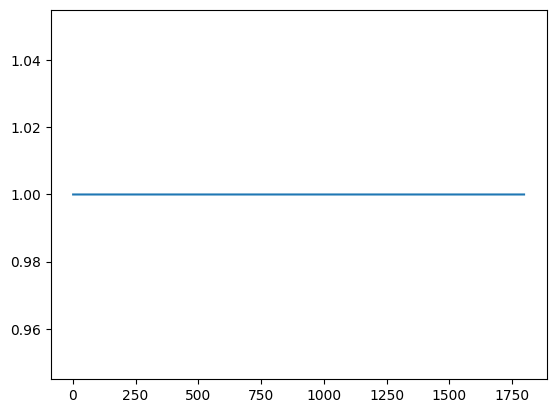

In [81]:
plt.plot(di)

ValueError: The input coordinate is not sorted in increasing order along axis 0. This can lead to unexpected results. Consider calling the `sortby` method on the input DataArray. To plot data with categorical axes, consider using the `heatmap` function from the `seaborn` statistical plotting library.

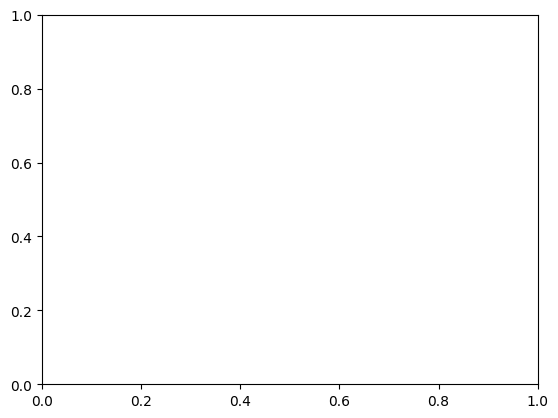

In [75]:
data['WVEL'].isel(time=0, k_l=10).plot()

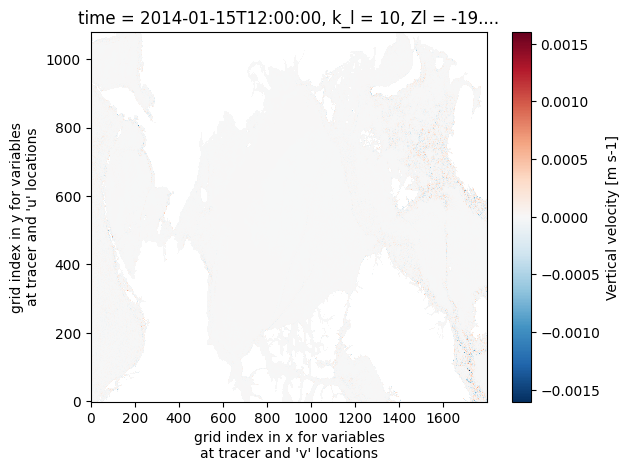

In [74]:
data_sample['WVEL'].isel(time=0, k_l=10).plot()

In [87]:
data_sample.i.values

array([   0,    1,    2, ..., 1797, 1798, 1799],
      shape=(1800,), dtype=int32)

In [88]:
i

array([      nan, 1.000e+00, 2.000e+00, ..., 1.797e+03, 1.798e+03,
       1.799e+03], shape=(1800,))

In [89]:
data.j.values

array([      nan, 1.000e+00, 2.000e+00, ..., 1.077e+03, 1.078e+03,
       1.079e+03], shape=(1080,))

In [90]:
data.k.values

array([nan,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89.])

In [91]:
data_sample.k.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89], dtype=int32)